# 端点から最大勾配方向へ向かって山登りすることで芯線を求める
[1] から順に実行していってください。（実行は シフトを押しながらEnter）

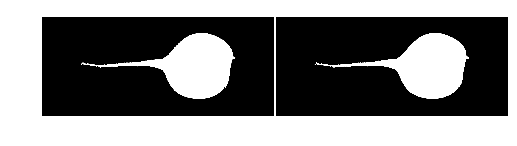

In [1]:
import radishlib as rdl
import cv2
%matplotlib inline
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

# 表示のオンオフ
IMGON = True

# 処理対象画像
imgfile = 'pics/cabubw.png'
# 表示のオンオフ
IMGON = True

# カラー画像の読み込み
src = cv2.imread(imgfile,0) 
gry = cv2.imread(imgfile,0)

# 同じ画像をグレー画像として読み込み
rdl.paraimage(src,gry)

In [2]:
thres = 80  # しきい値８０　で２階調化　　この値はこの実験画像限定
ret,bw=cv2.threshold(gry,thres,255,cv2.THRESH_BINARY)

kernel = np.ones((5,5),np.uint8)
# 白のゴミ取り　を２回実行
bw=cv2.morphologyEx(bw,cv2.MORPH_OPEN, kernel,iterations = 2)
# 黒のゴミ取りを２回実行
bw=cv2.morphologyEx(bw,cv2.MORPH_CLOSE, kernel,iterations = 2)

2 (714, 1662) [198091 988577] (2, 2)


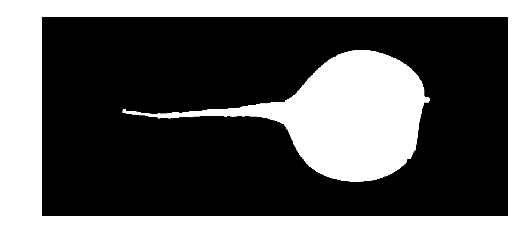

In [3]:
# 黒連結成分のラベリング 
output = cv2.connectedComponentsWithStats(~bw, connectivity = 8)
# Get the results
num_labels = output[0]  # 連結成分の数
labels = output[1] # ラベル画像
stats = output[2] # 属性情報の配列　cv2.CC_STAT_AREA番が面積me
menseki = stats[:,cv2.CC_STAT_AREA]
centroids = output[3]
print(num_labels,labels.shape,menseki,centroids.shape)

# 小領域の削除　　画像の縦の長さ＋横の長さより小さい面積の領域は無視する
img= np.zeros(gry.shape,dtype=np.uint8)
for i in range(1,num_labels ):
        if  stats[i][cv2.CC_STAT_AREA] > gry.shape[0]+gry.shape[1]:
            wb = img + np.uint8(labels==i)*255
bw = ~wb        
rdl.plotimg(bw)

In [4]:
# 結果確認のために色付け
import random

# ラベリングして色割当する関数
def showlabelimage(labels, num_labels):
    dst = copy.copy(src)
    colors = []
    for i in range(1, num_labels+1):
        colors.append(np.array([random.randint(100, 255), random.randint(0, 255), random.randint(0, 255)]))
    for y in range(0, labels.shape[0]):
        for x in range(0, labels.shape[1]):
            if labels[y, x] > 0:
                dst[y, x] = colors[labels[y, x]]
            else:
                dst[y, x] = [0, 0, 0]
    return dst

2 (714, 1662) [988577 198091] (2, 2)


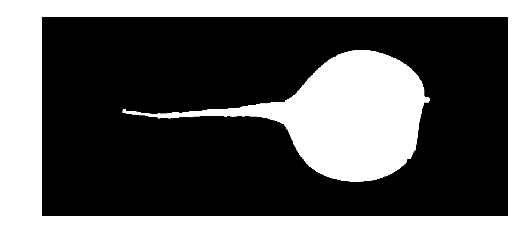

In [5]:
# 白連結成分のラベリング 
output = cv2.connectedComponentsWithStats(ｂｗ, connectivity = 4)  # 白領域の場合は４連結処理であることに注意
# Get the results
num_labels = output[0]  # 連結成分の数
labels = output[1] # ラベル画像
stats = output[2] # 属性情報の配列　cv2.CC_STAT_AREA番が面積me
menseki = stats[:,cv2.CC_STAT_AREA]
centroids = output[3]
print(num_labels,labels.shape,menseki,centroids.shape)
#  白連結成分にラベルをつけて表示してみる分かりやすく
# dst = showlabelimage(labels,num_labels)
dst = rdl.color2label(labels,num_labels)
rdl.plotimg(dst)

[0] [988577 198091] 0


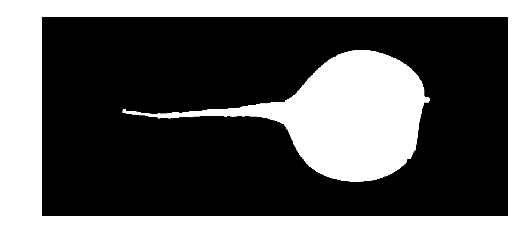

In [6]:
# 1番大きな領域がダイコンの主要部分であると仮定する。
sortedindex = menseki[1:].argsort()[::-1]  # ０番以外をソーティングしたときの値の多い順に index を並べたもの
dnum = sortedindex[0] # 1番多いデータのインデックス。
print(sortedindex,menseki,dnum)
# 最も大きな領域のみの画像を生成
daikonimg = np.uint8(labels==dnum+1)*255

rdl.plotimg(daikonimg)

In [7]:
# 距離画像変換　　各白画素について，最も近い黒画素までの距離をデータとする画像を生成
dist = cv2.distanceTransform(daikonimg,cv2.DIST_L2,5)

# 最大の距離は？　　　これが最大半径となる
maxR = np.max(dist)
maxPn = np.argmax(dist)
maxY = int(maxPn/dist.shape[1])
maxX = maxPn - maxY*dist.shape[1]
print("最大距離の画像位置(x,y) = (",maxX, ",",maxY,"),  maxR= ", maxR)

最大距離の画像位置(x,y) = ( 1124 , 368 ),  maxR=  223.397


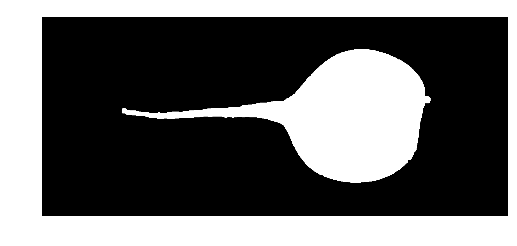

In [8]:
# 輪郭線の抽出
bw,pts = rdl.getContour(daikonimg,0)
xdata = [i[0][0]  for i in ｐｔｓ[0]]
ydata = [i[0][1]  for i in pts[0]]   

# 輪郭データの重複を取り除く
pts =  []
for i in range(len(xdata)):
    if [xdata[i],ydata[i]] not in pts:
        pts.append([xdata[i],ydata[i]] )
cpts = np.array(pts)

# plt.gca().set_aspect('equal',adjustable='box')
# plt.plot(cｐｔs[:,0],cpts[:,1],"r")
rdl.plotimg(rdl.drawRadishContour(daikonimg, cpts, 3,0,10))


＃　参考 
- [点列から曲率、曲率半径を求める（FastCode）](http://sach1o.blog80.fc2.com/blog-entry-96.html)
- http://d.hatena.ne.jp/ryamada/20141109/1415495218

![](http://blog-imgs-27.fc2.com/s/a/c/sach1o/discrete_curvature.gif)

```
# 各連続３点それぞれについて３つのベクトルを求める
def curvature(pts, samples = 100):
    sd = int(len(pts)/samples)
    v1 = pts[0:-2*sd:sd] - pts[sd:-sd:sd]  # P[i-1] - P[i]   （のリスト　　以下省略）
    v2 = pts[2*sd::sd] - pts[sd:-sd:sd]  # P[i +1]- P[i]   
    v3 = pts[2*sd::sd] - pts[0:-2*sd:sd] # p[i+1]-P[i-1]
    # ベクトルのノルム（長さ）を求める
    v1s = np.array([np.sqrt(np.dot(v1[i],v1[i]))  for i in range(len(v1))]) #  V1 のノルム（長さ）
    v2s = np.array([np.sqrt(np.dot(v2[i],v2[i]))  for i in range(len(v2))]) # V２ のノルム（長さ）
    v3s = np.array([np.sqrt(np.dot(v3[i],v3[i]))  for i in range(len(v3))]) # V３ のノルム（長さ）　　

    ppp = v1s*v2s*v3s # ３辺の長さの積（のリスト）

    ｃｐ = np.zeros(len(v1)) # 外積のノルムの大きさ格納用配列
    cp = np.abs(np.cross(v2, v1))

    # 曲率を求める
    #    cv = np.zeros(len(pts)) 
    # cv[sd:-sd] = 2*cp[sd:-sd]/ppp
    cv = np.zeros(len(v1)) 
    cv = 2*cp/ppp
    
    dl = np.zeros(len(v3s))  # 折れ線にそって測った距離
    dl = [np.sum(v3s[0:i]) for i in range(len(dl))]
    pt =pts[sd:-sd:sd]
    
    cvmaxind = np.argmax(cv)
    tip = pt[cvmaxind]
    print("曲率最大の点は",cvmaxind,"番のサンプル点で、曲率は",  cv[cvmaxind],"座標は", tip)
    
    return pt, dl , cv, tip  
    # pt: サンプル点,  
    # dl : サンプルの始点から測った折れ線近似された輪郭に沿って各点までの距離
    # cv: 距離率のリスト
 ```

曲率最大の点は 34 番のサンプル点で、曲率は 0.0752896303938 座標は [287 342]


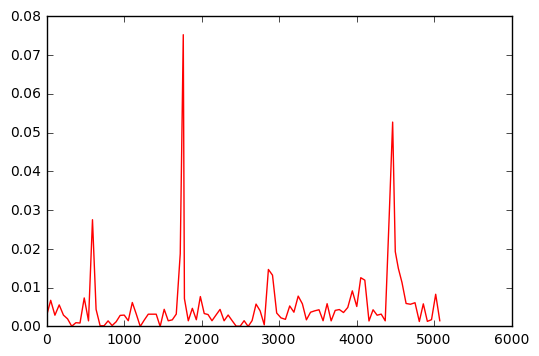

In [9]:
samples, curvelength, cvs, tippoint = rdl.curvature(cpts,samples=100)
len(samples), len(cvs), len(curvelength), tippoint,len(pts)
plt.plot(curvelength,cvs,"r")

In [10]:
dist2 = copy(dist)
skel = np.array(rdl.traceRidges1(tippoint[0],tippoint[1],0,dist2, 5))
skeldata = skel[skel[:,1].argsort()]    # この画像は大根が横向きなので，スケルトンを y の昇順に並べ替える

In [22]:
np.max(skeldata)

1382.0

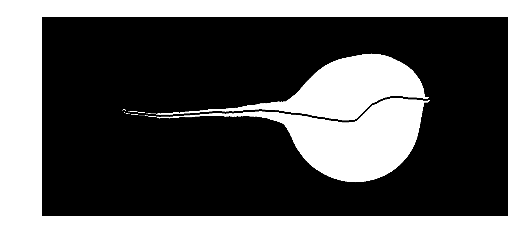

In [11]:
recallimg = rdl.skel2img(skeldata,src.shape)
rdl.plotimg(recallimg)

In [12]:
skd = skeldata
# 黒画素から最も距離のある，内部の点を基準点として選ぶ
normP = np.argmax(skd[:,2])
xnorm = skd[normP][1]
ynorm = skd[normP][0]
print (xnorm,ynorm)
print (len(skd))
print(np.max(skd[:,0]), np.max(skd[:1]))
print(normP)

1124.0 368.0
1096
376.0 342.0
837


In [13]:
# 基準点からの距離の配列を生成
distance = np.array([np.sign(x-xnorm)*np.sqrt((x-xnorm)**2 + (y - ynorm)**2)  for (y,x) in skd[:,0:2]] ) 
# 横向きの画像の場合は sign を x で決めるべきだが，縦ならば yに変えるべき

#基準点からの距離でインデックスを並べ替え
index = np.argsort(distance) # 距離順にインデックスを並べ替え
skd = skd[index] # スケルトンデータを距離順に並べ替え
distance = distance[index] # 距離データも並べ替え
skdp = np.array([ list(np.append(s,d)) for (s,d) in zip(skd,distance)])
# skpd はスケルトンの(y座標,x座標,輪郭までの距離,基準点からの距離)のリスト

#  並べ替えたので基準点のインデックスを再度調べ直す
normP = np.argmax(skd[:,2])
print (u'基準点',normP,'(',xnorm,ynorm,')')


基準点 837 ( 1124.0 368.0 )


（解説）径の一番太い位置の中心を基準点 normP として選び、その点からの距離でスケルトン画素を並べ換える。
もしスケルトンが直線状に並んでいるのならば求めた距離は中心軸に沿った距離に等しいが、湾曲している場合、
基準点からの直線距離と軸に沿って測った距離は基準から離れるほどズレが生じてくる。

形状を評価する場合、湾曲を補正した形状を求める必要があるが、それには直線距離ではなく、
軸に沿って測った距離を使うほうが適切である。

理屈の上では軸に沿って距離を積分、つまり積算していけばよいが、デジタル画像の場合近い点の距離は誤差が大きい。
例えば斜め45度に並ぶ点列の距離は1点ずつ距離を積算してしまうと実際の距離のルート２倍になってしまう。

そこで、曲がりが少ないであろう、１０点ごとに距離を測る基準点を設定し、
（基準点間距離＋最寄りの基準点からの距離）で、軸に沿った距離を近似する。

In [15]:
rdl.recalcDistanceP(skdp,normP)

左側修正量 8.59322627404515 (-837.4037258097196 -> -845.9969520837648)
右側修正量 18.104959134600733 (268.4026825499328 -> 286.50764168453355)


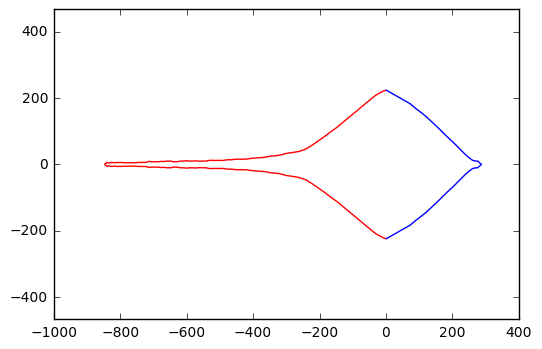

In [16]:
# @interact(invert=False)
def radiusfunc(invert=True):
    if invert:
        for d in skdp: d[3]=-d[3]
    skdN = skdp[skdp[:,3]<= 0] # 基準点より左のデータ
    skdP = skdp[skdp[:,3] > 0] # 基準点より右のデータ
    
    # 横軸を基点からのスケルトン位置までの距離，縦軸をそのスケルトンの距離データとしたグラフ                          
    plt.axis('equal')    
    plt.hold(True)
    ydata = np.array(skdN[:,2])
    xdata = np.array(skdN[:,3])
    plt.plot(xdata,ydata,'-',color=(1,0,0.0))
    plt.plot(xdata,-ydata,'-',color=(1,0,0.0))
    ydata = np.array(skdP[:,2])
    xdata = np.array(skdP[:,3])
    plt.plot(xdata,ydata,'-',color=(0,0,1.0))
    plt.plot(xdata,-ydata,'-',color=(0,0,1.0))
    plt.hold(False)
    plt.show()
    
    # invert で再描画する際には、グラフの描画を一旦停止すること。
    # 停止しないと描画されないので注意。
    
radiusfunc(invert=False)

中心軸の画素数=1096


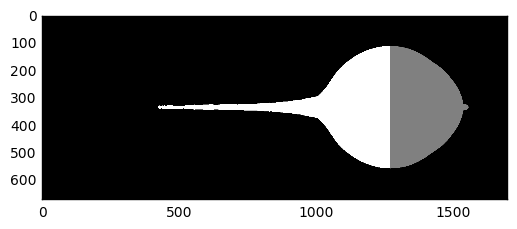

In [18]:
# 中心線を直線化して形状整形した画像の生成
norzimg = rdl.makeNormalizedImage(skdp)
rdl.plotimg(norzimg)

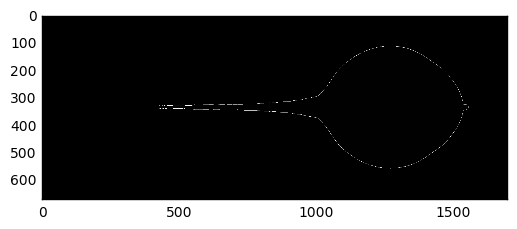

In [35]:
# 輪郭線の抽出
bw,cnt = rdl.getContour(norzimg,0)
cv2.drawContours(bw, cnt, 0, (255,255,255), 1)
rdl.plotimg(bw)

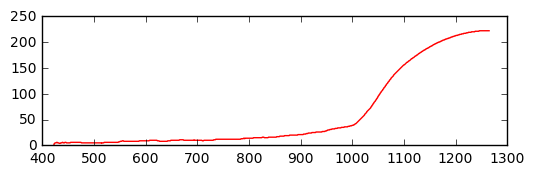

In [19]:
# 先端部分だけの点列の生成
bw,cnt = rdl.getContour(norzimg,2)
xdata = [i[0][0]  for i in cnt[0]]
ydata = [i[0][1]- bw.shape[0]/2 for i in cnt[0]] 
plt.gca().set_aspect('equal',adjustable='box')
plt.plot(xdata,ydata,"r")

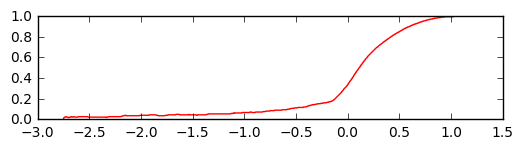

In [21]:
# 最大径を基準に正規化
xdataR = np.array(xdata)/maxR 
ydataR= np.array(ydata)/maxR
xdataR,ydataR = rdl.shiftX(xdataR,ydataR,1/3)    # y = 1/3 付近が x=0 になるようにデータ全体をｘ軸に沿ってシフト
plt.gca().set_aspect('equal',adjustable='box')
plt.plot(xdataR,ydataR,"r")

    0:(a,b,err) = (    0.0853,    0.0000,     0.1014)
  200:(a,b,err) = (    3.0862,    0.0801,     0.0048)
  400:(a,b,err) = (    3.8847,    0.1090,     0.0015)
  600:(a,b,err) = (    4.2826,    0.1166,     0.0007)
  800:(a,b,err) = (    4.5167,    0.1198,     0.0004)
 1000:(a,b,err) = (    4.6655,    0.1215,     0.0003)
 1200:(a,b,err) = (    4.7642,    0.1224,     0.0002)
 1400:(a,b,err) = (    4.8313,    0.1230,     0.0002)
 1600:(a,b,err) = (    4.8778,    0.1234,     0.0002)
 1800:(a,b,err) = (    4.9104,    0.1236,     0.0002)
 2000:(a,b,err) = (    4.9334,    0.1238,     0.0002)


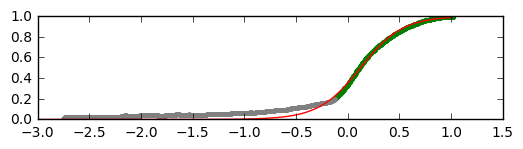

In [23]:
from fit1 import fit1
fit1((xdataR,ydataR),itr = 2000, alpha=1.0, xmin=-3, xmax=1,cutoff=0.2)

# 原因はわからないが，１度目は描画に失敗するようである．２回目はうまくいく．